# The Bus Stop Paradox: Theory and Reality

If you are, like me, a frequent public transit commuter, you may be familiar with the following situation:

*You arrive at the bus stop, ready to catch your bus: a line that advertises buses every 10 minutes. You glance at your watch and note the time... and when the bus finally comes 11 minutes later, you wonder why you always seem to be so unlucky.*

Naively, you might expect that if buses are coming every 10 minutes and you arrive at a random time, your average wait would be something like 5 minutes.
In reality, though, buses do not arrive exactly on schedule, and so you might wait longer.
It turns out that under some reasonable assumptions, you can reach a startling conclusion:

**When waiting for a bus that comes every 10 minutes, your average waiting time will be 10 minutes.**

This is what is sometimes known as the *bus stop paradox* or the *waiting time paradox*.

I've encountered this idea before, and always wondered whether it is actually true... how well do those "reasonable assumptions" reflect reality?
This post will explore the bus stop paradox from the standpoint of both simulation and probability theory, and then take a look at some real bus arrival time data from the city of Seattle to (hopefully) settle the paradox once and for all.

## The Inspection Paradox

Qualitatively speaking, it's easy to convince yourself that the average wait time for a 10-minute bus line should be somewhat longer than the 5 minutes you might expect

The bus stop paradox above turns out to be a special instance of a more general phenomenon, the *inspection paradox*, which is discussed at length in this enlightening post by Allen Downey: [The Inspection Paradox Is Everywhere](
http://allendowney.blogspot.com/2015/08/the-inspection-paradox-is-everywhere.html).

Briefly, the inspection paradox arises whenever the probability of observing a quantity is related to the quantity being observed.
Allen gives one example of surveying university students about the average size of their classes. Though the school may truthfully advertise an average of 30 students per class, the average class size *as experienced by students* can be much larger. The reason is that there are (of course) more students in the larger classes, and so you oversample large classes when computing the average.

In the case of a bus line, sometimes the span between arrivals will be longer than 10 minutes, and sometimes shorter, and if you arrive at a random time, you are more likely to encounter a long interval than a short interval because there are more opportunities to do so. And so the average span of time experienced by riders will be longer than the average span of time between buses.

But the waiting time paradox makes a stronger claim than this: when the average span between arrivals is $N$ minutes, the average span *experienced by riders* is $2N$ minutes.
Could this possibly be true?

## Simulating Wait Times

To convince ourselves that this is reasonable, let's start by simulating a stream of buses that arrive at an average of 10 minutes.
For the sake of numerical accuracy, we will simulate a large number of bus arrivals: one million buses (or approximately 19 years of round-the-clock 10-minute headways):

In [1]:
import numpy as np

N = 1000000  # number of buses
tau = 10  # average minutes between arrivals

rand = np.random.RandomState(42)  # universal random seed
bus_arrival_times = N * tau * np.sort(rand.rand(N))

Just to confirm we've done things correctly, let's check that the mean interval is close to 12:

In [2]:
intervals = np.diff(bus_arrival_times)
intervals.mean()

9.9999879601518398

The intervals between buses average about 10 minutes, as advertised.

With these bus arrivals in place, we can now simulate the arrival of a large number of passengers to the bus stop during this span, and compute the wait time that each of them experiences:

In [80]:
def simulate_wait_times(arrival_times, N=1000000, rseed=5743980):
    rand = np.random.RandomState(rseed)
    
    arrival_times = np.asarray(arrival_times)
    passengers = arrival_times.min() + arrival_times.ptp() * rand.rand(N)

    # find the index of the next bus for each passenger
    i = np.searchsorted(arrival_times, passengers, side='right')

    return arrival_times[i] - passengers

wait_times = simulate_wait_times(bus_arrival_times)

With these computed, we can find the average wait time:

In [81]:
wait_times.mean()

9.9952208767501833

The average wait time is also close to 10 minutes, just as the bus stop paradox predicted.

## Digging Deeper: Poisson Processes and Exponential Distributions

How can we understand what's going on here?
As mentioned above, the bus stop paradox can be understood qualitatively as an example of the inspection paradox.

The inspection paradox comes up in any situation where your probability of measuring a quantity is related to the quantity itself: here, that quantity is effectively the actual (not scheduled) time interval between buses, and our probability of observing any interval is affected by the length of that interval.
So to proceed, we'll nee the probability distribution of intervals between buses.

Rather than commit to any particular distribution right now, let's use $p(T)$ to denote the probability distribution of arrival intervals $T$.
In this notation, the expectation value of the arrival times is
$$
E[T] = \int_0^\infty T~p(T)~dT
$$
In the above simulation, we had chosen $E[T] = \tau = 10$ minutes.

When a rider arrives at a bus stop at a random time, the probability of the time interval they experience will be affected by $p(T)$, but also by $T$ itself: the longer the interval, the larger the probability is that a passenger will experience it.

So we can write the distribution of arrival times experienced by passengers:
$$
p_{exp}(T) \propto T~p(T)
$$
The constant of proportionality comes from normalizing the distribution:
$$
p_{exp}(T) = \frac{T~p(T)}{\int_0^\infty T~p(T)~dT}
$$
Comparing to above we see this simplifies to
$$
p_{exp}(T) = \frac{T~p(T)}{E[T]} 
$$
The expected wait time will then be half of the expected interval experienced by passengers, so we can write
$$
E_{exp}[W] = \frac{1}{2}E_{exp}[T] = \frac{1}{2}\int_0^\infty T~p_{exp}(T)~dT
$$
which can be rewritten in a more suggestive way:
$$
E[W] = \frac{E[T^2]}{2E[T]}
$$
and now all that remains is for us to quantify $p(T)$ and compute the integrals.

### Choosing p(T)

With this formalism worked out, what should we choose for the distribution $p(T)$?
We can get a picture of the $p(T)$ distribution within our simulation by plotting a histogram of the simulated intervals:

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

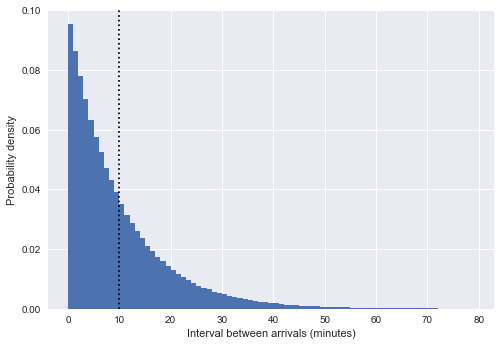

In [6]:
plt.hist(intervals, bins=np.arange(80), density=True)
plt.axvline(intervals.mean(), color='black', linestyle='dotted')
plt.xlabel('Interval between arrivals (minutes)')
plt.ylabel('Probability density');

The vertical dotted line here shows the mean interval of about 10 minutes.
This looks very much like an exponential distribution, and that is no accident: our simulation of bus arrival times very closely approximates a [Poisson process](https://en.wikipedia.org/wiki/Poisson_point_process), and for such a process it can be shown that the distribution of intervals between arrivals is exponential.

(In our case this is only approximately exponential; in reality the intervals $T$ between $N$ uniformly sampled points in an interval $N\tau$ follow the [Beta distribution](https://en.wikipedia.org/wiki/Beta_distribution): $T/(N\tau) \sim \mathrm{Beta}[1, N]$, which in the large $N$ limit approaches $T \sim \mathrm{Exp}[1/\tau]$.
See, e.g. this [StackExchange post](https://math.stackexchange.com/questions/68749/difference-of-order-statistics-in-a-sample-of-uniform-random-variables)... and thanks to folks on [this twitter thread](https://twitter.com/jakevdp/status/1038086415190351872) for the references!).

To double-check this interpretation, we can note that a Poisson process will show a Poisson-distributed number of arrivals within any particular span of time; as a sanity check let's bin our simulated arrivals into hourly blocks and check that the counts are consistent with a Poisson distribution:

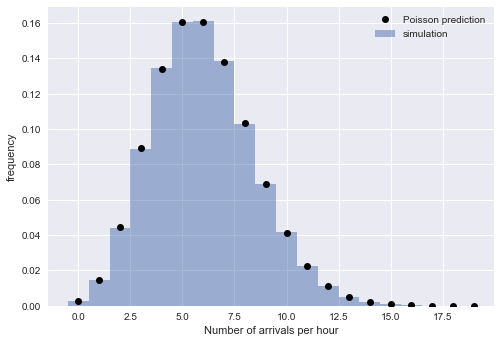

In [7]:
from scipy.stats import poisson

# count the number of arrivals in 1-hour bins
binsize = 60
binned_arrivals = np.bincount((bus_arrival_times // binsize).astype(int))
x = np.arange(20)

# plot the results
plt.hist(binned_arrivals, bins=x - 0.5, density=True, alpha=0.5, label='simulation')
plt.plot(x, poisson(binsize / tau).pmf(x), 'ok', label='Poisson prediction')
plt.xlabel('Number of arrivals per hour')
plt.ylabel('frequency')
plt.legend();

This gives confidence that our interpretation is correct: for large $N$, the random bus arrival times are well-described by a Poisson process, which has exponentially-distributed inter-arrival times.

That means we can write the probability distribution:
$$
p(T) = \frac{1}{\tau}e^{-T/\tau}
$$
Plugging this into the above results, we find that the average waiting time experienced by a person is
$$
E[W] = \frac{\int_0^\infty T^2~e^{-T/\tau}}{2\int_0^\infty T~e^{-T/\tau}} = \frac{2\tau^3}{2(\tau^2)} = \tau
$$
The expected wait time for a passenger is exactly the average interval between arrivals.

A complementary way to reason about this is this: a Poisson process is a *memoryless* process, meaning that the history of events has no bearing on the expected time to the next event.
So when you arrive at the bus stop, the average waiting time until the next bus is always the same: in our case, it is 10 minutes, and this is regardless of whether you missed the previous bus by one second or one hour!
Similarly, it does not matter how long you have been waiting already: the expected time to the next arrival is always exactly 10 minutes: for a Poisson process, you get no "credit" for time already waited.

## Waiting Times In Reality

The above is well and good if bus arrivals are actually described by a Poisson process, but are they?
To determine whether the waiting time paradox describes reality, we can dig into some data.
The following data contains scheduled and actual arrival times for the [Rapid Ride](https://kingcounty.gov/depts/transportation/metro/travel-options/bus/rapidride.aspx) C, D, and E lines at the 3rd & Pike bus stop in downtown Seattle, recorded over two months in 2016:

In [8]:
import pandas as pd
df = pd.read_csv('rapid-ride-CDE-2016-raw.csv')
df = df.dropna(axis=0, how='any')
df.head()

,OPD_DATE,VEHICLE_ID,RTE,DIR,TRIP_ID,STOP_ID,STOP_NAME,SCH_STOP_TM,ACT_STOP_TM
0,2016-03-26,6201,673,S,30908177,431,3RD AVE & PIKE ST (431),01:11:57,01:13:19
1,2016-03-26,6201,673,S,30908033,431,3RD AVE & PIKE ST (431),23:19:57,23:16:13
2,2016-03-26,6201,673,S,30908028,431,3RD AVE & PIKE ST (431),21:19:57,21:18:46
3,2016-03-26,6201,673,S,30908019,431,3RD AVE & PIKE ST (431),19:04:57,19:01:49
4,2016-03-26,6201,673,S,30908252,431,3RD AVE & PIKE ST (431),16:42:57,16:42:39


The nice thing about the Rapid Ride routes is that for much of the day, their schedule has regular headways of between 10 and 15 minutes.

### Data Cleanup

To start with, do a little bit of data cleanup to make this more useful:

In [9]:
# combine date and time into a single timestamp
df['scheduled'] = pd.to_datetime(df['OPD_DATE'] + ' ' + df['SCH_STOP_TM'])
df['actual'] = pd.to_datetime(df['OPD_DATE'] + ' ' + df['ACT_STOP_TM'])

# if scheduled & actual span midnight, then the actual day needs to be adjusted
minute = np.timedelta64(1, 'm')
hour = 60 * minute
diff_hrs = (df['actual'] - df['scheduled']) / hour
df.loc[diff_hrs > 20, 'actual'] -= 24 * hour
df.loc[diff_hrs < -20, 'actual'] += 24 * hour
df['minutes_late'] = (df['actual'] - df['scheduled']) / minute

# map route numbers to route letters
df['route'] = df['RTE'].replace({673: 'C', 674: 'D', 675: 'E'}).astype('category')
df['direction'] = df['DIR'].replace({'N': 'northbound', 'S': 'southbound'}).astype('category')

# extract useful columns
df = df[['route', 'direction', 'scheduled', 'actual', 'minutes_late']].copy()

df.head()

,route,direction,scheduled,actual,minutes_late
0,C,southbound,2016-03-26 01:11:57,2016-03-26 01:13:19,1.366667
1,C,southbound,2016-03-26 23:19:57,2016-03-26 23:16:13,-3.733333
2,C,southbound,2016-03-26 21:19:57,2016-03-26 21:18:46,-1.183333
3,C,southbound,2016-03-26 19:04:57,2016-03-26 19:01:49,-3.133333
4,C,southbound,2016-03-26 16:42:57,2016-03-26 16:42:39,-0.300000


There are essentially six different datasets in here: the northbound and southbound directions for each of the C, D, and E lines.
To get a feeling for their characteristics, let's plot a histogram of the actual minus scheduled arrival times for each of these six:

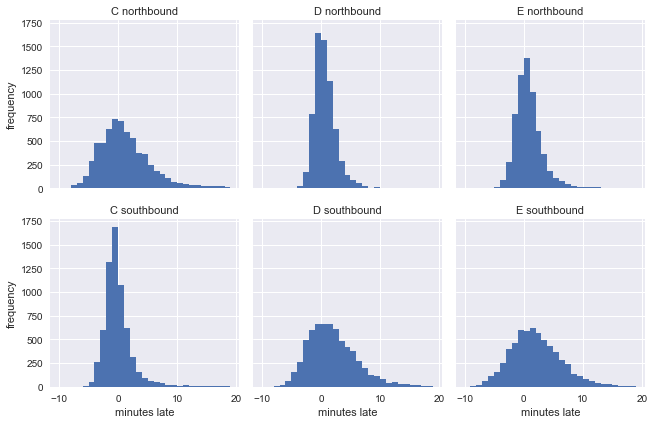

In [10]:
import seaborn as sns
g = sns.FacetGrid(df, row="direction", col="route")
g.map(plt.hist, "minutes_late", bins=np.arange(-10, 20))
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('minutes late', 'frequency');

You might expect that the buses stick closer to their schedule near the beginning of each one-way trip, and this is borne out in the data: the C-line starts downtown and heads south, while the D and E lines start downtown and head north.

### Scheduled and Observed Arrival Intervals

Let's next take a look at the observed and scheduled intervals between arrivals for these six routes.
We'll start by using Pandas `groupby` functionality to compute these:

In [11]:
compute_headway = lambda scheduled: scheduled.sort_values().diff() / minute
grouped = df.groupby(['route', 'direction'])
df['actual_interval'] = grouped['actual'].transform(compute_headway)
df['scheduled_interval'] = grouped['scheduled'].transform(compute_headway)

First we will look at the observed interval between bus arrivals:

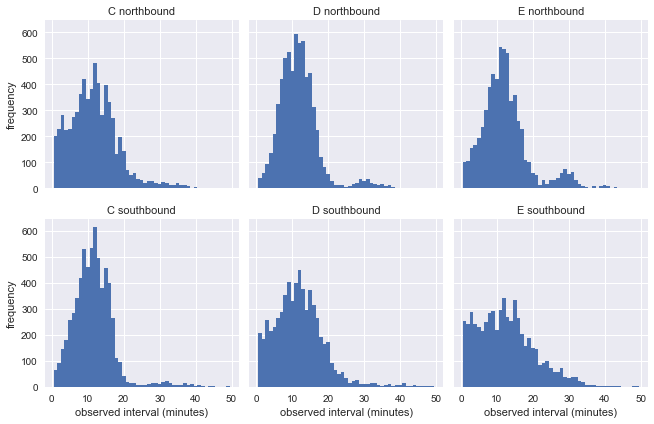

In [12]:
g = sns.FacetGrid(df.dropna(), row="direction", col="route")
g.map(plt.hist, "actual_interval", bins=np.arange(50) + 0.5)
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('observed interval (minutes)', 'frequency');

It's already clear that these don't look much like the exponential distribution of our model, but that is not telling us much yet: the distributions may be affected by non-constant scheduled arrival intervals.

Let's repeat the above chart, with scheduled rather than observed arrival intervals:

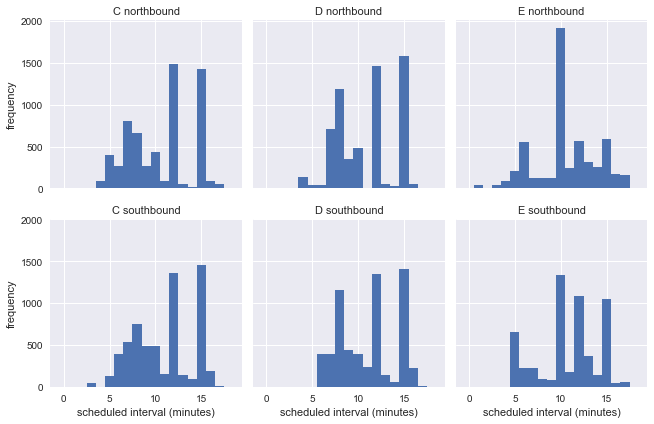

In [13]:
g = sns.FacetGrid(df.dropna(), row="direction", col="route")
g.map(plt.hist, "scheduled_interval", bins=np.arange(20) - 0.5)
g.set_titles('{col_name} {row_name}')
g.set_axis_labels('scheduled interval (minutes)', 'frequency');

This shows that the buses come at variety of arrival intervals thorughout the week, so we cannot evaluate the accuracy of the bus stop paradox from the distributions of raw arrival times.

### Extracting Uniform Sequences

Even though the scheduled arrival intervals are not uniform, there are a few particular intervals that have a large number of arrivals: for example, there are nearly 2000 northbound E-line buses that have a scheduled interval of 10 minutes.
We could create an artificial data set that is reflective of reality by grouping the data by line, direction, and scheduled interval, then stacking all these similar arrivals together as if they happened in sequence.

Here is a function that does just that:

In [14]:
def reconstruct_headway(data):
    data = data.sort_values('scheduled')
    data['scheduled'] = data['scheduled_interval'].cumsum()
    data['actual'] = data['scheduled'] + data['minutes_late']
    data['actual_interval'] = data['actual'].sort_values().diff()
    return data

subset = df[df.scheduled_interval.isin([10, 12, 15])]
grouped = subset.groupby(['route', 'direction', 'scheduled_interval'])
sequenced = grouped.apply(reconstruct_headway).reset_index(drop=True)
sequenced.head()

,route,direction,scheduled,actual,minutes_late,actual_interval,scheduled_interval
0,C,northbound,10.0,12.400000,2.400000,NaN,10.0
1,C,northbound,20.0,27.150000,7.150000,0.183333,10.0
2,C,northbound,30.0,26.966667,-3.033333,14.566667,10.0
3,C,northbound,40.0,35.516667,-4.483333,8.366667,10.0
4,C,northbound,50.0,53.583333,3.583333,18.066667,10.0


Using this cleaned data, we can plot the distribution of "observed" arrival intervals for buses of a given scheduled arrival; we'll choose the most frequent scheduled intervals for each bus line:

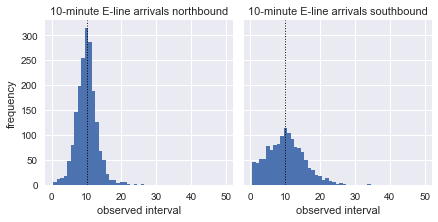

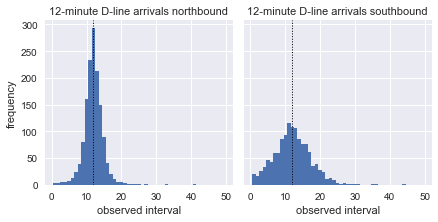

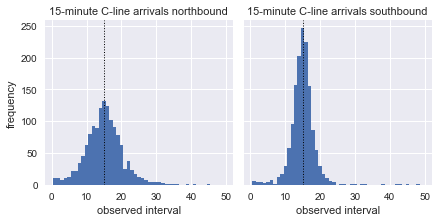

In [15]:
from scipy import stats

def plot_arrivals(data, route, interval):
    subset = data.query(f"route == {route!r} & scheduled_interval == {interval!r}")
    g = sns.FacetGrid(subset.dropna(), col="direction")
    g.map(plt.hist, "actual_interval", bins=np.arange(50) + 0.5)
    g.map(plt.axvline, x=interval, color='black', linestyle='dotted', linewidth=1)
    g.set_titles(f'{interval}-minute {route}-line arrivals {{col_name}}')
    g.set_axis_labels('observed interval', 'frequency');

plot_arrivals(sequenced, 'E', 10)
plot_arrivals(sequenced, 'D', 12)
plot_arrivals(sequenced, 'C', 15)

The result is clear: the distribution of observed arrival intervals is nearly Gaussian and peaked near the scheduled interval, with a standard deviation that is smaller near the beginning of the route and larger near the end.
Even without a statistical test, it's clear by eye that the intervals are definitely **not** exponentially distributed, and so the fundamental assumption beneath the bus stop paradox is false.

With this cleaned and resequenced data, we can use our simulation approach to find the average wait time for each bus and scheduled headway:

In [82]:
sims = sequenced.groupby(['route', 'direction', 'scheduled_interval'])['actual'].apply(simulate_wait_times)
sims.apply(lambda times: "{0:.1f} +/- {1:.1f}".format(times.mean(), times.std()))

route  direction   scheduled_interval
C      northbound  10.0                  7.8 +/- 12.6
                   12.0                   7.4 +/- 5.6
                   15.0                   8.8 +/- 6.4
       southbound  10.0                   6.2 +/- 6.3
                   12.0                   6.8 +/- 5.2
                   15.0                   8.4 +/- 7.2
D      northbound  10.0                   6.1 +/- 7.1
                   12.0                   6.5 +/- 4.6
                   15.0                   7.9 +/- 5.3
       southbound  10.0                   6.7 +/- 5.3
                   12.0                   7.5 +/- 5.9
                   15.0                   8.8 +/- 6.4
E      northbound  10.0                   5.5 +/- 3.7
                   12.0                   6.5 +/- 4.3
                   15.0                   7.9 +/- 4.9
       southbound  10.0                   6.8 +/- 5.6
                   12.0                   7.3 +/- 5.2
                   15.0                   8.

The average waiting times are are slightly longer than half the scheduled interval, but not equal to the scheduled interval as the waiting time paradox implied. In other words, the inspection paradox is confirmed, but the waiting time paradox is shown to be empirically inaccurate.

To get a better idea of the distribution of rider experiences, we can plot the full distribution of waiting times for any of these re-sequenced routes.
For example, here are the simulated waiting times for the northbound and southbound 10-minute E-line:

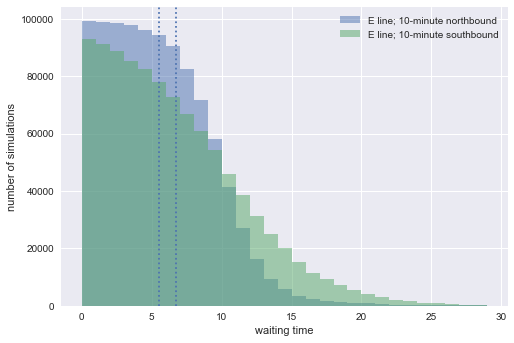

In [97]:
for direction in ['northbound', 'southbound']:
    waits = sims.loc[('E', direction, 10)]
    plt.hist(waits, bins=np.arange(30), alpha=0.5,
             label=f'E line; 10-minute {direction}')
    plt.axvline(waits.mean(), linestyle='dotted')
    
plt.xlabel('waiting time')
plt.ylabel('number of simulations')
plt.legend();

Notice that although the average wait time is 5-6 minutes, there is a small chance for either line of experiencing very long waits: sometimes as large as 20 or 25 minutes for the spread-out southbound buses!
But the average waiting time is not near to matching the scheduled interval, and I content that the above analysis shows difinitively that the core assumption behind the bus stop paradox — that the arrival of buses follows the statistics of a Poisson process — is not well-founded.

In retrospect, this is not particularly surprising: a Poisson process is a memoryless process that assumes the  probability of an arrival is entirely independent of the time since the previous arrival.
In reality, a well-run bus system will have schedules deliberately structured to avoid this kind of behavior: buses don't begin their routes at random times throughout the day, but rather begin their routes on a schedule chosen to best serve the transit-riding public.

If there is any lesson here, it is that you should be careful about the assumptions you bring to any task.
Just because one type of data sounds like another type of data (for example, arrival times), it does not mean they are statistically similar.
Often assumptions that seem correct on their face can lead to conclusions that don't match reality.